In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import seaborn as sns
from autorocks.viz import viz
from autorocks.viz import plots_setup
import matplotlib.pyplot as plt
import torch
import gpytorch
import botorch.posteriors
from botorch import models
from botorch.optim import fit
import torch
import numpy as np
import pandas as pd
import botorch


class Forrester(botorch.test_functions.SyntheticTestFunction):

    dim = 1
    _bounds = [(0.0, 1.0)]
    _optimal_value = -6.0
    _optimizers = [(0.78)]

    def evaluate_true(self, X: torch.Tensor) -> torch.Tensor:
        return torch.pow(6 * X - 2, 2) * torch.sin(12 * X - 4)


problem = Forrester(negate = True)


In [23]:
num_observations = 5
train_x_full, train_y_full = plots_setup.generate_data(num_observations, problem)


In [24]:
model = models.FixedNoiseGP(
    train_X=train_x_full,
    train_Y=train_y_full,
    train_Yvar=torch.zeros_like(train_y_full)
)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
fit.fit_gpytorch_scipy(mll)


/Users/samialabed/miniconda3/envs/bograph_causal_edp/lib/python3.8/site-packages/botorch/models/gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(
/Users/samialabed/miniconda3/envs/bograph_causal_edp/lib/python3.8/site-packages/gpytorch/likelihoods/noise_models.py:144: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


(ExactMarginalLogLikelihood(
   (likelihood): FixedNoiseGaussianLikelihood(
     (noise_covar): FixedGaussianNoise()
   )
   (model): FixedNoiseGP(
     (likelihood): FixedNoiseGaussianLikelihood(
       (noise_covar): FixedGaussianNoise()
     )
     (mean_module): ConstantMean()
     (covar_module): ScaleKernel(
       (base_kernel): MaternKernel(
         (lengthscale_prior): GammaPrior()
         (raw_lengthscale_constraint): Positive()
         (distance_module): Distance()
       )
       (outputscale_prior): GammaPrior()
       (raw_outputscale_constraint): Positive()
     )
   )
 ),
 {'fopt': 2.4989707469940186,
  'wall_time': 0.037101166999946145,
  'iterations': [],
  'OptimizeResult':   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
    success: True
     status: 0
        fun: 2.4989707469940186
          x: [-2.052e+00  4.333e+00 -1.576e+00]
        nit: 16
        jac: [ 3.448e-05 -4.668e-06 -3.543e-05]
       nfev: 47
       njev: 47
   hess_inv: <3x3 LbfgsInvH

In [25]:
test_x = torch.linspace(0, 1, 100)
test_y = problem(test_x)
cr = plots_setup.predict(model = model, test_x = test_x, observation_noise = False)

lower, upper, mean = cr.lower, cr.upper, cr.mean
sorted_x = np.argsort(test_x)

# plot the test_x as an x axis, then plot the mean prediction, fill the lower and upper
# then plot the observed x and y


Saving:  /Users/samialabed/Workspace/latex_writings/thesis/phd_dissertation/Chapters/Background/Figures/bo_loop_gp.png
Saving:  /Users/samialabed/Workspace/latex_writings/thesis/phd_dissertation/Chapters/Background/Figures/bo_loop_gp.pdf
Saving:  /Users/samialabed/Workspace/latex_writings/thesis/phd_dissertation/Chapters/Background/Figures/bo_loop_gp.svg


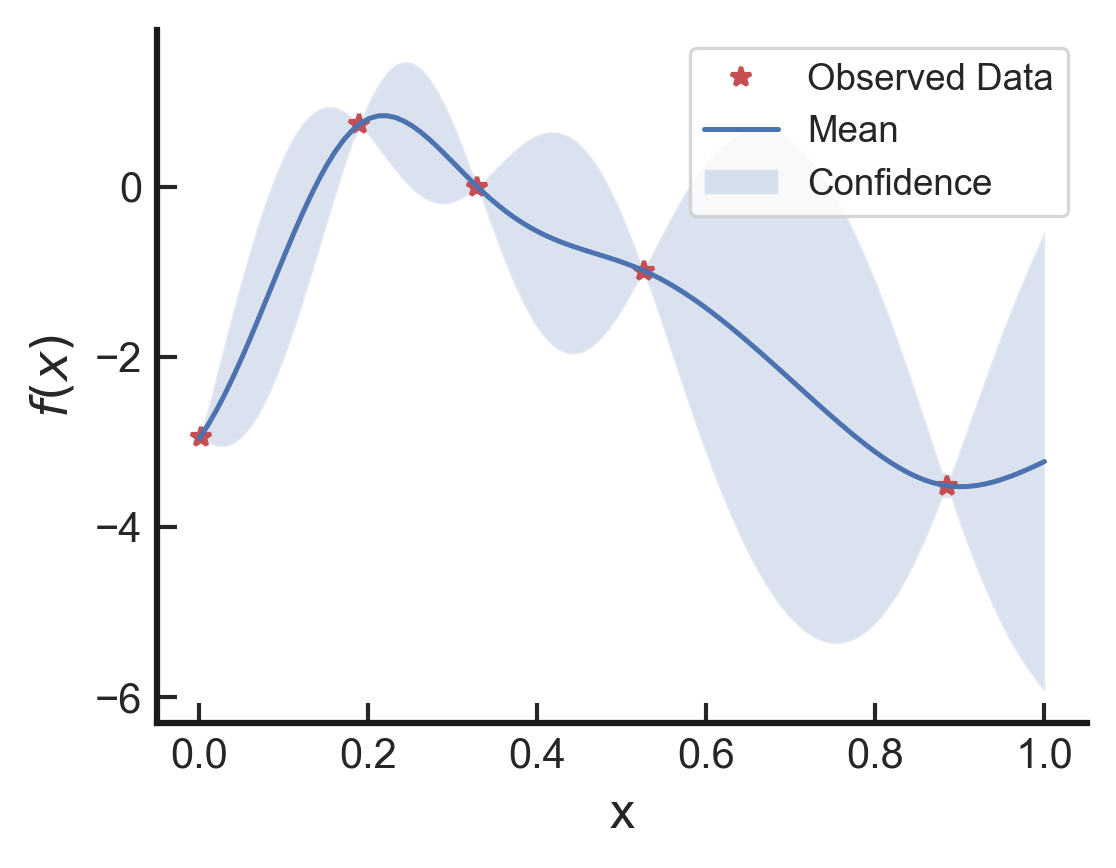

In [28]:
 # Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

# Plot training data as red stars
ax.plot(train_x_full.numpy(), train_y_full.numpy(), 'r*')
# Plot predictive means as blue line
ax.plot(test_x.numpy(), mean.numpy(), 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.numpy(), lower.squeeze().numpy(), upper.squeeze().numpy(), alpha=0.2)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
ax.set_xlabel("x")
ax.set_ylabel("$f(x)$")

viz.save_figure(filename="bo_loop_gp", chapter="Background", figure=f)

/var/folders/d7/s_0dbzz10dg7rnj9n14nllhm0000gn/T/ipykernel_2213/335265425.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data.explode(column=["f(x)", "x"]), x="x", y="f(x)", ax=ax, palette = "hls")


Saving:  /Users/samialabed/Workspace/latex_writings/thesis/phd_dissertation/Chapters/Background/Figures/bo_loop_acf.png
Saving:  /Users/samialabed/Workspace/latex_writings/thesis/phd_dissertation/Chapters/Background/Figures/bo_loop_acf.pdf
Saving:  /Users/samialabed/Workspace/latex_writings/thesis/phd_dissertation/Chapters/Background/Figures/bo_loop_acf.svg


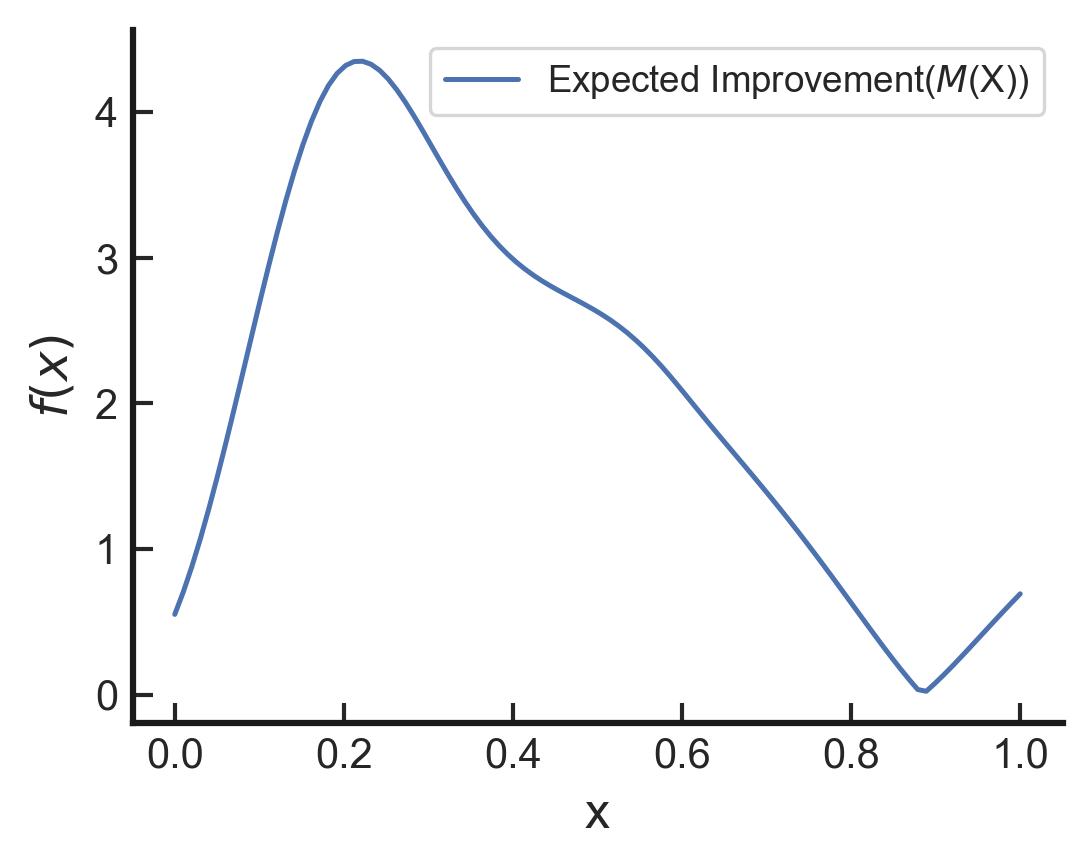

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad():
    ei = botorch.acquisition.ExpectedImprovement(model, best_f = train_y_full.min())(test_x.reshape(-1, 1, 1))

data = pd.DataFrame([
    {'AF': 'EI', 'f(x)': ei.numpy(), "x": test_x.numpy() },
])

# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

ax = sns.lineplot(data.explode(column=["f(x)", "x"]), x="x", y="f(x)", ax=ax, palette = "hls")
ax.legend(['Expected Improvement($M(X)$)'])
ax.set_ylabel("$f(x)$")

viz.save_figure(filename="bo_loop_acf", chapter="Background", figure=f)